In [8]:
from data_loader import load_latest_iteration
from config_generator import physics_config_generator


import subprocess
import os
import numpy as np
import pandas as pd

In [9]:
mode = "hard"
END_RADIUS = 5

In [10]:
BIN_FOLDER = f"../code/cpp/build/src"

DATA_FOLDER = f"../code/cpp/build/src/vtk_output_{mode}/data"

In [11]:
base_physics_config = {
    'LAMBDA': 1e-3,
} if mode == "hard" else {
    'LAMBDA': 1e-3,
    'k_cc': 2000.0,
    'alpha': 0.5,
}

variation = {
    "k_cc": {"type": "percent", "value": 0.95},     # ±95%
    "LAMBDA": {"type": "magnitude", "value": 2},    # ±2 orders of magnitude
    "alpha": {"type": "percent", "value": 0.95},    # ±95%
}

dt = 1/1000 if mode == "hard" else 1/10000

generator = physics_config_generator(
    base_physics_config, variation, num_samples=5, distribution="uniform", seed=42)

In [12]:
def save_simulation_data(params, final_state, simulation, filename="simulation_data.pkl"):
    """
    Save or append a simulation datapoint (parameters + final state) to a persistent dataset.
    """

    # Load existing dataset
    if os.path.exists(filename):
        df = pd.read_pickle(filename)
    else:
        df = pd.DataFrame(columns=["parameters", "final_state"])

    # Ensure params and final_state are stored as single objects
    new_row = {"parameters": params,
               "final_state": final_state, "simulation": simulation}

    # Use pd.DataFrame([new_row]) to make sure each cell holds the object
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    df.to_pickle(filename)
    return df

In [13]:

def run_simulation(config):
    print(config)

    args = " ".join([f"-{key} {value}" for key, value in config.items()])

    args += f" -end_radius {END_RADIUS} -dt {dt}"

    process = subprocess.Popen(
        f"make -j && mpirun -np 18 ./cellcollectives -mode {mode} {args}", shell=True, cwd=BIN_FOLDER, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)

    while process.stdout.readable():
        line = process.stdout.readline()

        if not line:
            break

        print(line.strip(), end="\r")

    print()

    data = load_latest_iteration(DATA_FOLDER)

    particles = data["particles"]
    params = data["parameters"]
    simulation = data["simulation"]

    save_simulation_data(params, particles, simulation,
                         f"simulation_data_{mode}.pkl")

In [14]:
for i, config in enumerate(generator):
    run_simulation(config)

{'LAMBDA': np.float64(0.003611662782147248)}
b'Colony radius: 5.0 / 5.0 (100.0%) | Time: 5.6 | ETA: -0.0 min | dt:  0.0s | CPU: 10.4s | Iter: 5613 | Particles: 12' | Memory: 47.56 MB'
Latest iteration 0 is not the same as the global latest iteration 54
{'LAMBDA': np.float64(1.2590501261927495e-05)}
b'Colony radius: 5.0 / 5.0 (100.0%) | Time: 3.0 | ETA: -0.0 min | dt:  0.0s | CPU: 6.0s | Iter: 3008 | Particles: 16'0 | Memory: 39.64 MB'
Latest iteration 0 is not the same as the global latest iteration 28
{'LAMBDA': np.float64(0.0001259265408043701)}
b'Colony radius: 5.0 / 5.0 (100.0%) | Time: 3.1 | ETA: -0.0 min | dt:  0.0s | CPU: 5.3s | Iter: 3056 | Particles: 16'0 | Memory: 45.74 MB'
Latest iteration 0 is not the same as the global latest iteration 29
{'LAMBDA': np.float64(7.813452073384151e-05)}
b'Colony radius: 5.0 / 5.0 (100.0%) | Time: 3.0 | ETA: -0.0 min | dt:  0.0s | CPU: 4.7s | Iter: 3037 | Particles: 16'0 | Memory: 41.65 MB'
Latest iteration 0 is not the same as the global late

In [15]:
# Load the dataset
df = pd.read_pickle(f"simulation_data_{mode}.pkl")

# Number of simulation runs
print(len(df))       # number of rows

7


In [16]:
def extract_param_value(obj, param):
    """Extract parameter value and handle numpy arrays"""
    if not hasattr(obj, 'get'):
        return None

    value = obj.get(param, None)

    if value is None:
        return None

    # Handle numpy arrays
    if hasattr(value, 'shape'):
        if value.shape == (1,):  # Shape (1,) -> scalar
            return value.item()
        # Shape (n, 1) -> flatten to (n,)
        elif len(value.shape) == 2 and value.shape[1] == 1:
            return value.flatten()
        elif value.shape == ():  # Shape () -> scalar
            return value.item()
        else:
            return value  # Keep as is for other shapes

    return value

In [17]:
df["final_state"][0]

,gid,quaternion_x,quaternion_y,quaternion_z,quaternion_w,orientation_x,orientation_y,orientation_z,lengths_x,lengths_y,...,velocity_linear_x,velocity_linear_y,velocity_linear_z,velocity_angular_x,velocity_angular_y,velocity_angular_z,rank,x,y,z
0,1.0,1.000000,0.0,0.0,-0.000136,1.000000,-0.000271,0.0,1.00385,0.5,...,-2.391850e-17,-8.069500e-18,0.0,0.0,0.0,-1.190280e-17,7,-3.631340,-0.000095,0.0
1,2.0,0.999998,0.0,0.0,-0.001776,0.999994,-0.003552,0.0,1.01816,0.5,...,-6.246280e-18,2.099090e-17,0.0,0.0,0.0,9.306240e-18,7,-2.630000,-0.000474,0.0
0,9.0,1.000000,0.0,0.0,-0.000020,1.000000,-0.000040,0.0,1.11643,0.5,...,6.589750e-16,-6.107140e-16,0.0,0.0,0.0,1.716160e-16,11,4.687440,-0.000007,0.0
0,5.0,0.999972,0.0,0.0,-0.007484,0.999888,-0.014967,0.0,1.11115,0.5,...,-2.684160e-19,2.484440e-19,0.0,0.0,0.0,7.422770e-18,9,0.554664,0.000358,0.0
1,6.0,0.999987,0.0,0.0,-0.005138,0.999947,-0.010277,0.0,1.03742,0.5,...,-4.813660e-18,2.255870e-17,0.0,0.0,0.0,-3.602810e-18,9,1.618950,0.000761,0.0
0,0.0,1.000000,0.0,0.0,-0.000016,1.000000,-0.000032,0.0,1.15134,0.5,...,6.665260e-16,-6.177130e-16,0.0,0.0,0.0,1.835060e-16,6,-4.700270,0.000007,0.0
0,3.0,0.999986,0.0,0.0,-0.005338,0.999943,-0.010677,0.0,1.03805,0.5,...,5.695920e-18,2.800050e-18,0.0,0.0,0.0,7.106160e-18,8,-1.611810,-0.000766,0.0
1,4.0,0.999971,0.0,0.0,-0.007567,0.999885,-0.015134,0.0,1.11214,0.5,...,-5.526620e-18,-6.480040e-18,0.0,0.0,0.0,-3.361920e-18,8,-0.546819,-0.000323,0.0


In [18]:

def plot_radial_distribution(particles, variable, bin_size=1):
    """
    Plot radial distribution of a variable.

    Args:
        particles: DataFrame containing particle data
        variable: String name of the variable to analyze or 'packing_fraction_soft'/'packing_fraction_hard'
        bin_size: Size of radial bins
        fig: Optional figure to plot on
    """
    # Calculate radial distances
    particles["dist_center"] = np.sqrt(
        particles["x"]**2 + particles["y"]**2 + particles["z"]**2)

    # Create radial bins
    max_radius = int(particles["dist_center"].max())
    r_edges = np.arange(0, max_radius + bin_size, bin_size)
    r_centers = (r_edges[1:] + r_edges[:-1]) / 2

    # Calculate values in each shell
    var_vals = []
    for i in range(len(r_centers)):
        mask = (particles["dist_center"] >= r_edges[i]) & (
            particles["dist_center"] < r_edges[i+1])
        shell_particles = particles[mask]

        val = shell_particles[variable].mean() if len(
            shell_particles) > 0 else 0

        var_vals.append(val)

    var_vals = np.array(var_vals)

    return r_centers, var_vals


def pressure_theoretical(r, R, LAMBDA):
    c = (np.sqrt((1 + LAMBDA * R**2 / 2)) - 1) / (2 * LAMBDA * R**2)

    return 2 / LAMBDA * np.log(1/(8*c) - c * LAMBDA * r**2)


def error_stress(r_centers, avg_stress, LAMBDA):
    R = r_centers[-1]
    p_theoretical = pressure_theoretical(r_centers, R, LAMBDA)

    return np.sqrt(np.mean((avg_stress - p_theoretical)**2))

In [19]:
# Now create the DataFrame
X = pd.DataFrame({
    param: df["parameters"].apply(lambda x: extract_param_value(x, param))
    for param in base_physics_config.keys()
}, index=df["parameters"].index)


def calculate_stress_fit(final_state, params):
    r_centers, avg_stress = plot_radial_distribution(
        final_state, "stress", bin_size=3)

    R = r_centers[-1]
    LAMBDA = params[0]["LAMBDA"][0]

    p_theoretical = pressure_theoretical(r_centers, R, LAMBDA)

    error = np.sqrt(np.mean((avg_stress - p_theoretical)**2))

    return error

In [20]:
df["final_state"]

0       gid  quaternion_x  quaternion_y  quaternion...
1        gid  quaternion_x  quaternion_y  quaternio...
2        gid  quaternion_x  quaternion_y  quaternio...
3        gid  quaternion_x  quaternion_y  quaternio...
4        gid  quaternion_x  quaternion_y  quaternio...
5        gid  quaternion_x  quaternion_y  quaternio...
6        gid  quaternion_x  quaternion_y  quaternio...
Name: final_state, dtype: object

In [21]:
df["parameters"][0]

,dt_s,end_radius,log_frequency_seconds,min_box_size_x,min_box_size_y,min_box_size_z,xi,TAU,l0,LAMBDA,...,max_bbpgd_iterations,max_recursive_iterations,linked_cell_size,growth_factor,particle_preallocation_factor,mode,x,y,z,rank
0,0.001,5.0,0.1,2.0,2.0,0.0,1.0,1.0,1.0,0.016016,...,100000,50,2.2,1.5,12.0,0,NaN,NaN,NaN,0


In [22]:
X = pd.DataFrame({
    param: df["parameters"].apply(lambda x: extract_param_value(x, param))
    for param in base_physics_config.keys()
}, index=df["parameters"].index)


# Extract basic simulation parameters
y = pd.DataFrame({
    "error_stress": df["final_state"].apply(lambda x: calculate_stress_fit(x, df["parameters"])),
    "num_particles": df["simulation"].apply(lambda x: extract_param_value(x, "num_particles")),
    "colony_radius": df["simulation"].apply(lambda x: extract_param_value(x, "colony_radius")),
    "particle_length_variance": df["final_state"].apply(
        lambda x: extract_param_value(x, "lengths_x").var()),
}, index=df["parameters"].index)


def spherocylinder_area(length, radius=0.25):
    """
    Calculate projected area of a spherocylinder
    Area = rectangle + 2 semicircles = 2*r*L + π*r²
    """
    return 2 * radius * (length-2*radius) + np.pi * radius**2


# Calculate average particle dimensions
average_length = df["final_state"].apply(
    lambda x: extract_param_value(x, "lengths_x").mean())

# Area-based density (2D packing fraction)
y["area_density"] = (spherocylinder_area(average_length) * y["num_particles"]) / \
    (y["colony_radius"]**2 * np.pi)

In [23]:
X.describe()

,LAMBDA
count,7.000000
mean,0.004374
std,0.006019
min,0.000013
25%,0.000102
50%,0.001944
75%,0.006220
max,0.016016


In [24]:
y.describe()

,error_stress,num_particles,colony_radius,particle_length_variance,area_density
count,7.000000,7.000000,7.000000,7.000000e+00,7.000000
mean,233.521750,13.857143,4.966539,2.781875e-02,0.102261
std,72.580958,2.734262,0.037230,6.114452e-02,0.020948
min,182.351699,10.000000,4.894900,2.632000e-07,0.061622
25%,200.318686,11.500000,4.952150,5.476588e-06,0.097110
50%,206.791835,16.000000,4.981280,3.040670e-03,0.110763
75%,225.527882,16.000000,4.992855,1.297286e-02,0.115745
max,393.815577,16.000000,4.999580,1.657336e-01,0.117731


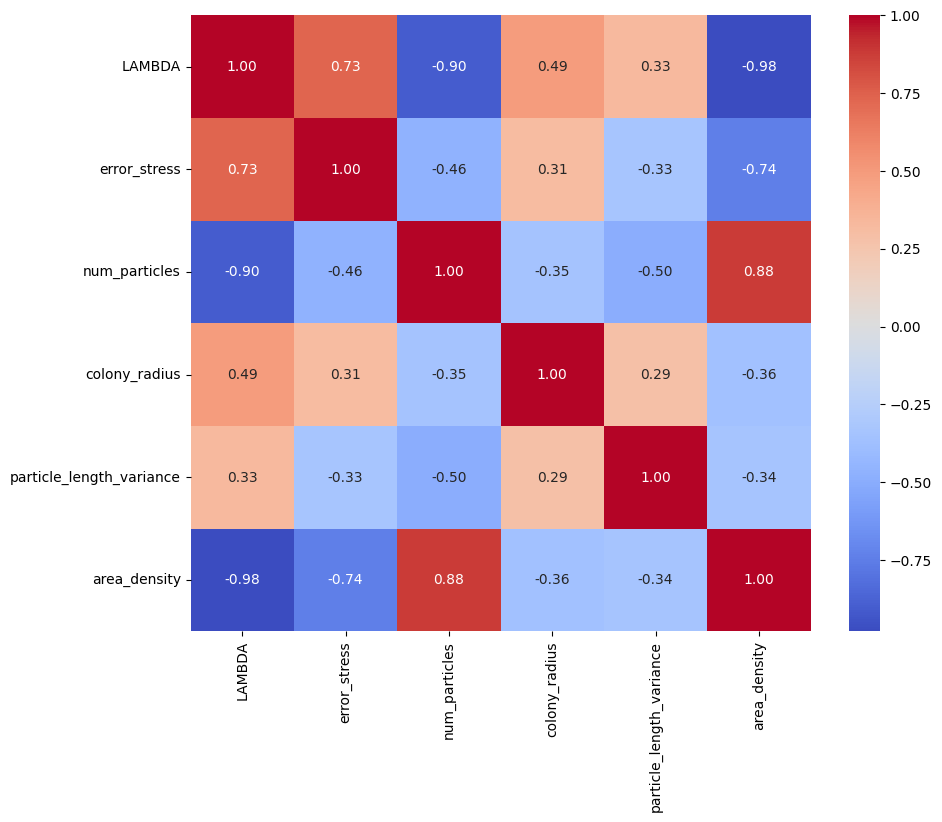

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X and y are DataFrames
data = pd.concat([X, y], axis=1)

# Compute correlation matrix
corr = data.corr(numeric_only=True)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

for target in y.columns:

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = LinearRegression()
    model.fit(X_scaled, y[target])

    # Coefficients
    coeffs = pd.Series(model.coef_, index=X.columns)

    eq_str = f"{target} = " + \
        " + ".join([f"{coeffs[i]:.2e} * {X.columns[i]}" for i in range(len(coeffs))])

    print(eq_str)

error_stress = 4.93e+01 * LAMBDA
num_particles = -2.28e+00 * LAMBDA
colony_radius = 1.71e-02 * LAMBDA
particle_length_variance = 1.90e-02 * LAMBDA
area_density = -1.90e-02 * LAMBDA


/tmp/ipykernel_269684/2040245987.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  " + ".join([f"{coeffs[i]:.2e} * {X.columns[i]}" for i in range(len(coeffs))])
/tmp/ipykernel_269684/2040245987.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  " + ".join([f"{coeffs[i]:.2e} * {X.columns[i]}" for i in range(len(coeffs))])
/tmp/ipykernel_269684/2040245987.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  " + ".join([f"{coeffs[

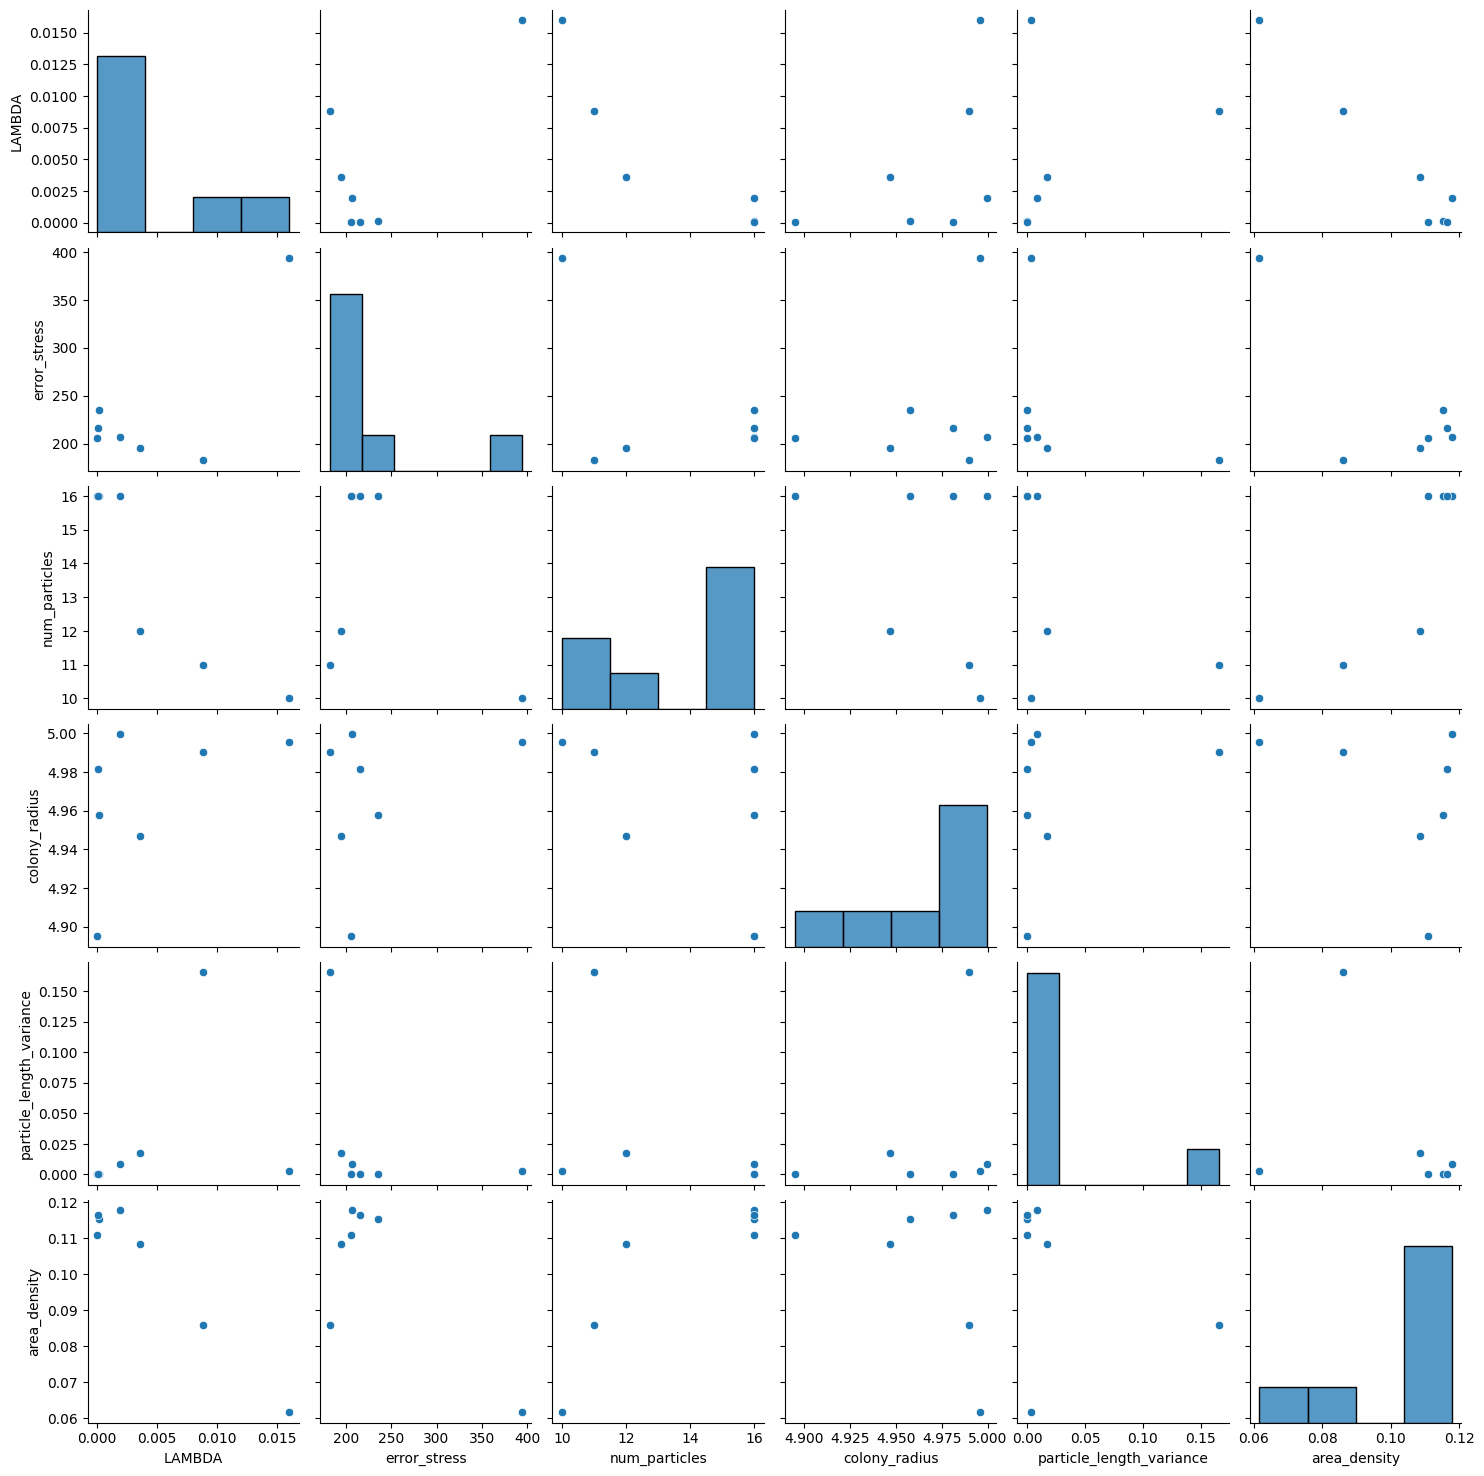

In [27]:
sns.pairplot(pd.concat([X, y], axis=1))
plt.show()